In [1]:
base_directory = '/home/shoaib/ZTFDataChallenge/'

import sys
sys.path.insert(0, base_directory + 'dmdt_Analysis/')
from dmdt_functions import *

In [2]:
import numpy as np
import pandas as pd
from os import listdir

import warnings
warnings.filterwarnings("ignore")

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers=10)

from tqdm.auto import tqdm
tqdm.pandas(desc="Lightcurves Processed")

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5)

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.rcParams['axes.grid'] = False
# plt.style.use('seaborn-v0_8-colorblind')

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
### Loading the lightcurves by name
lightcurves_by_name = pd.read_pickle(base_directory + 'lightcurves_by_name.pkl')[['name', 'type', 'r_lightcurve', 'g_lightcurve']]
# lightcurves_by_name = lightcurves_by_name.dropna(axis=0)
# lightcurves_by_name = lightcurves_by_name.query("type in @qso_types")
### Sampling to save memory
# lightcurves_by_name = lightcurves_by_name.sample(frac=0.1)

### Loading the lightcurves by OID
lightcurves_by_oid = pd.read_pickle(base_directory + 'lightcurves_by_oid.pkl')[['oid_alerce', 'name', 'band', 'type', 'lightcurve']]
# lightcurves_by_oid = lightcurves_by_oid.dropna(axis=0)
# lightcurves_by_oid = lightcurves_by_oid.query("type in @qso_types")
### Sampling to save memory
# lightcurves_by_oid = lightcurves_by_oid.sample(frac=0.1)

In [4]:
qso_types = ['Q', 'QR', 'QX']

### Let's do a series of bins

In [5]:
def lightcurve_binner(bins, mjd_array, magnitude_array, err_magnitude_array):
    binned_mjd = []
    binned_magnitude = []
    binned_err_magnitude = []
    
    bin_indices = np.digitize(mjd_array, bins)
    
    for i in range(1, len(bins)):
        mask = bin_indices == i
        if np.any(mask):
            weights = 1 / err_magnitude_array[mask]**2

            mean_mjd = np.mean(mjd_array[mask])
            weighted_magnitude = np.average(magnitude_array[mask], weights=weights)
            combined_err_magnitude = np.sqrt(1 / weights.sum())

            binned_mjd.append(mean_mjd)
            binned_magnitude.append(weighted_magnitude)
            binned_err_magnitude.append(combined_err_magnitude)
    
    binned_mjd = np.array(binned_mjd)
    binned_magnitude = np.array(binned_magnitude)
    binned_err_magnitude = np.array(binned_err_magnitude)
    return np.column_stack((binned_mjd, binned_magnitude, binned_err_magnitude))

def apply_dayscale_binning(interval, lightcurve):
    if not isinstance(lightcurve, np.ndarray):
        return np.nan
    mjd_array = lightcurve[:, 0]
    magnitude_array = lightcurve[:, 1]
    err_magnitude_array = lightcurve[:, 2]
    bins = np.arange(int(mjd_array.min()), np.ceil(mjd_array.max()), interval)
    
    binned_lightcurve = lightcurve_binner(bins, mjd_array, magnitude_array, err_magnitude_array)
    if binned_lightcurve.shape[0] < 2:
        return np.nan
    return binned_lightcurve

In [6]:
bin_intervals = [1, 5, 10, 20, 30, 50, 100, 200]

In [7]:
for interval in bin_intervals:
    lightcurves_by_name[f'r_lightcurve_{interval}days'] = lightcurves_by_name['r_lightcurve'].parallel_apply(lambda lc: apply_dayscale_binning(interval, lc))
    lightcurves_by_name[f'r_n_good_det_{interval}days'] = lightcurves_by_name[f'r_lightcurve_{interval}days'].apply(lambda lc: lc.shape[0] if isinstance(lc, np.ndarray) else np.nan)
    lightcurves_by_name[f'r_timespan_good_{interval}days'] = lightcurves_by_name[f'r_lightcurve_{interval}days'].apply(lambda lc: lc[:, 0].max() - lc[:, 0].min() if isinstance(lc, np.ndarray) else np.nan)

    lightcurves_by_name[f'g_lightcurve_{interval}days'] = lightcurves_by_name['g_lightcurve'].parallel_apply(lambda lc: apply_dayscale_binning(interval, lc))
    lightcurves_by_name[f'g_n_good_det_{interval}days'] = lightcurves_by_name[f'g_lightcurve_{interval}days'].apply(lambda lc: lc.shape[0] if isinstance(lc, np.ndarray) else np.nan)
    lightcurves_by_name[f'g_timespan_good_{interval}days'] = lightcurves_by_name[f'g_lightcurve_{interval}days'].apply(lambda lc: lc[:, 0].max() - lc[:, 0].min() if isinstance(lc, np.ndarray) else np.nan)

In [8]:
for interval in bin_intervals:
    lightcurves_by_name[f'r_dmdt_curve_{interval}days'] = lightcurves_by_name[f'r_lightcurve_{interval}days'].apply(lambda lc: differentiate_lightcurve(lc) if isinstance(lc, np.ndarray) else np.nan)
    lightcurves_by_name[f'g_dmdt_curve_{interval}days'] = lightcurves_by_name[f'g_lightcurve_{interval}days'].apply(lambda lc: differentiate_lightcurve(lc) if isinstance(lc, np.ndarray) else np.nan)

## We will the LCs and differenciated curves of different bins

### Lightcurves by Name

In [9]:
def plot_single_subfig(subfig, ncols, row):
    object_name = row['name']
    object_type = row['type']

    axs = subfig.subplots(nrows=1, ncols=ncols)
    for i, interval in enumerate(bin_intervals):
        r_lightcurve, g_lightcurve = row[f'r_lightcurve_{interval}days'], row[f'g_lightcurve_{interval}days']
        r_dmdt_curve, g_dmdt_curve = row[f'r_dmdt_curve_{interval}days'], row[f'g_dmdt_curve_{interval}days']

        draw_lightcurve(ax=axs[i * 2], band='r', lightcurve=r_lightcurve)
        draw_lightcurve(ax=axs[i * 2], band='g', lightcurve=g_lightcurve)
        axs[i * 2].set_title(f'{interval}-Day Binned, ({r_lightcurve.shape[0]} $r$, {g_lightcurve.shape[0]} $g$ epochs)')

        draw_dmdt_curve(ax=axs[(i * 2) + 1], band='r', timeseries=r_dmdt_curve)
        draw_dmdt_curve(ax=axs[(i * 2) + 1], band='g', timeseries=g_dmdt_curve)
        axs[(i * 2) + 1].set_title(f'{interval}-Day Binned $\\frac{{dM}}{{dt}}$')

    
    subfig.suptitle(f'{object_name} | Type: {object_type}', size=16, y=1.02)
    subfig.subplots_adjust(wspace=0.3)
    return axs

In [10]:
lightcurves_by_name

,name,type,r_lightcurve,g_lightcurve,r_lightcurve_1days,r_n_good_det_1days,r_timespan_good_1days,g_lightcurve_1days,g_n_good_det_1days,g_timespan_good_1days,r_lightcurve_5days,r_n_good_det_5days,r_timespan_good_5days,g_lightcurve_5days,g_n_good_det_5days,g_timespan_good_5days,r_lightcurve_10days,r_n_good_det_10days,r_timespan_good_10days,g_lightcurve_10days,g_n_good_det_10days,g_timespan_good_10days,r_lightcurve_20days,r_n_good_det_20days,r_timespan_good_20days,g_lightcurve_20days,g_n_good_det_20days,g_timespan_good_20days,r_lightcurve_30days,r_n_good_det_30days,r_timespan_good_30days,g_lightcurve_30days,g_n_good_det_30days,g_timespan_good_30days,r_lightcurve_50days,r_n_good_det_50days,r_timespan_good_50days,g_lightcurve_50days,g_n_good_det_50days,g_timespan_good_50days,r_lightcurve_100days,r_n_good_det_100days,r_timespan_good_100days,g_lightcurve_100days,g_n_good_det_100days,g_timespan_good_100days,r_lightcurve_200days,r_n_good_det_200days,r_timespan_good_200days,g_lightcurve_200days,g_n_good_det_200days,g_timespan_good_200days,r_dmdt_curve_1days,g_dmdt_curve_1days,r_dmdt_curve_5days,g_dmdt_curve_5days,r_dmdt_curve_10days,g_dmdt_curve_10days,r_dmdt_curve_20days,g_dmdt_curve_20days,r_dmdt_curve_30days,g_dmdt_curve_30days,r_dmdt_curve_50days,g_dmdt_curve_50days,r_dmdt_curve_100days,g_dmdt_curve_100days,r_dmdt_curve_200days,g_dmdt_curve_200days
0,1AXG J000605+2031,AX,"[[58268.4470486, 17.2935829, 0.0198369212], [5...","[[58268.4661921, 17.2914085, 0.0193178076], [5...","[[58268.4470486, 17.2935829, 0.0198369212], [5...",206.0,962.716157,"[[58268.4661921, 17.2914085, 0.0193178076], [5...",211.0,962.670093,"[[58269.9449016, 17.28494317031654, 0.01396308...",110.0,960.198403,"[[58268.4661921, 17.2914085, 0.0193178076], [5...",109.0,961.689323,"[[58272.949074075004, 17.29508178663367, 0.009...",64.0,957.194230,"[[58272.9640567, 17.296353365714705, 0.0136949...",64.0,950.494520,"[[58277.4583416, 17.312465593523726, 0.0075756...",36.0,952.684963,"[[58279.25317592001, 17.323250025832667, 0.008...",36.0,942.113149,"[[58282.05143866, 17.31316933014933, 0.0063405...",24.0,930.517113,"[[58285.563049111115, 17.349605730468568, 0.00...",25.0,927.454367,"[[58291.7565899875, 17.323737813157695, 0.0050...",15.0,896.420990,"[[58295.78968209334, 17.37085797237432, 0.0052...",15.0,894.673530,"[[58318.04846715937, 17.345657568693728, 0.003...",9.0,793.836716,"[[58317.895134339284, 17.384195775324912, 0.00...",9.0,792.869551,"[[58347.456602441176, 17.366925311117722, 0.00...",4.0,674.410116,"[[58350.10528236249, 17.40666055454899, 0.0029...",4.0,660.396909,"[[58268.4470486, -0.005716248523717843, 0.0093...","[[58268.4661921, 0.0011050910692161112, 0.0030...","[[58269.9449016, 0.003412076216753215, 0.00330...","[[58268.4661921, 0.0011050910692161112, 0.0030...","[[58272.949074075004, 0.00395603590881216, 0.0...","[[58272.9640567, 0.004361070086402661, 0.00170...","[[58277.4583416, 0.0007227345008713001, 0.0005...","[[58279.25317592001, 0.0038182751258282427, 0....","[[58282.05143866, 0.0012311980696874802, 0.000...","[[58285.563049111115, 0.001874096378112951, 0....","[[58291.7565899875, 0.0008544301506541599, 0.0...","[[58295.78968209334, 0.0006133781083722527, 0....","[[58318.04846715937, 0.0007540707510076801, 7....","[[58317.895134339284, 0.0007237909755336035, 7...","[[58347.456602441176, -0.000155310162824234, 3...","[[58350.10528236249, -9.654552359269556e-05, 3..."
1,1AXG J035008-1149,AX,"[[58432.3809954, 19.886844600000003, 0.1277610...","[[58390.4113657, 19.8996181, 0.129595727], [58...","[[58432.3809954, 19.886844600000003, 0.1277610...",4.0,316.086638,"[[58390.4113657, 19.8996181, 0.129595727], [58...",5.0,359.060802,"[[58432.3809954, 19.886844600000003, 0.1277610...",4.0,316.086638,"[[58390.4113657, 19.8996181, 0.129595727], [58...",4.0,358.470880,"[[58435.844033600006, 19.838636683508167, 0.08...",2.0,311.624327,"[[58390.4113657, 19.8996181, 0.129595727], [58...",4.0,358.470880,"[[58435.844033600006, 19.838636683508167, 0.08...",2.0,311

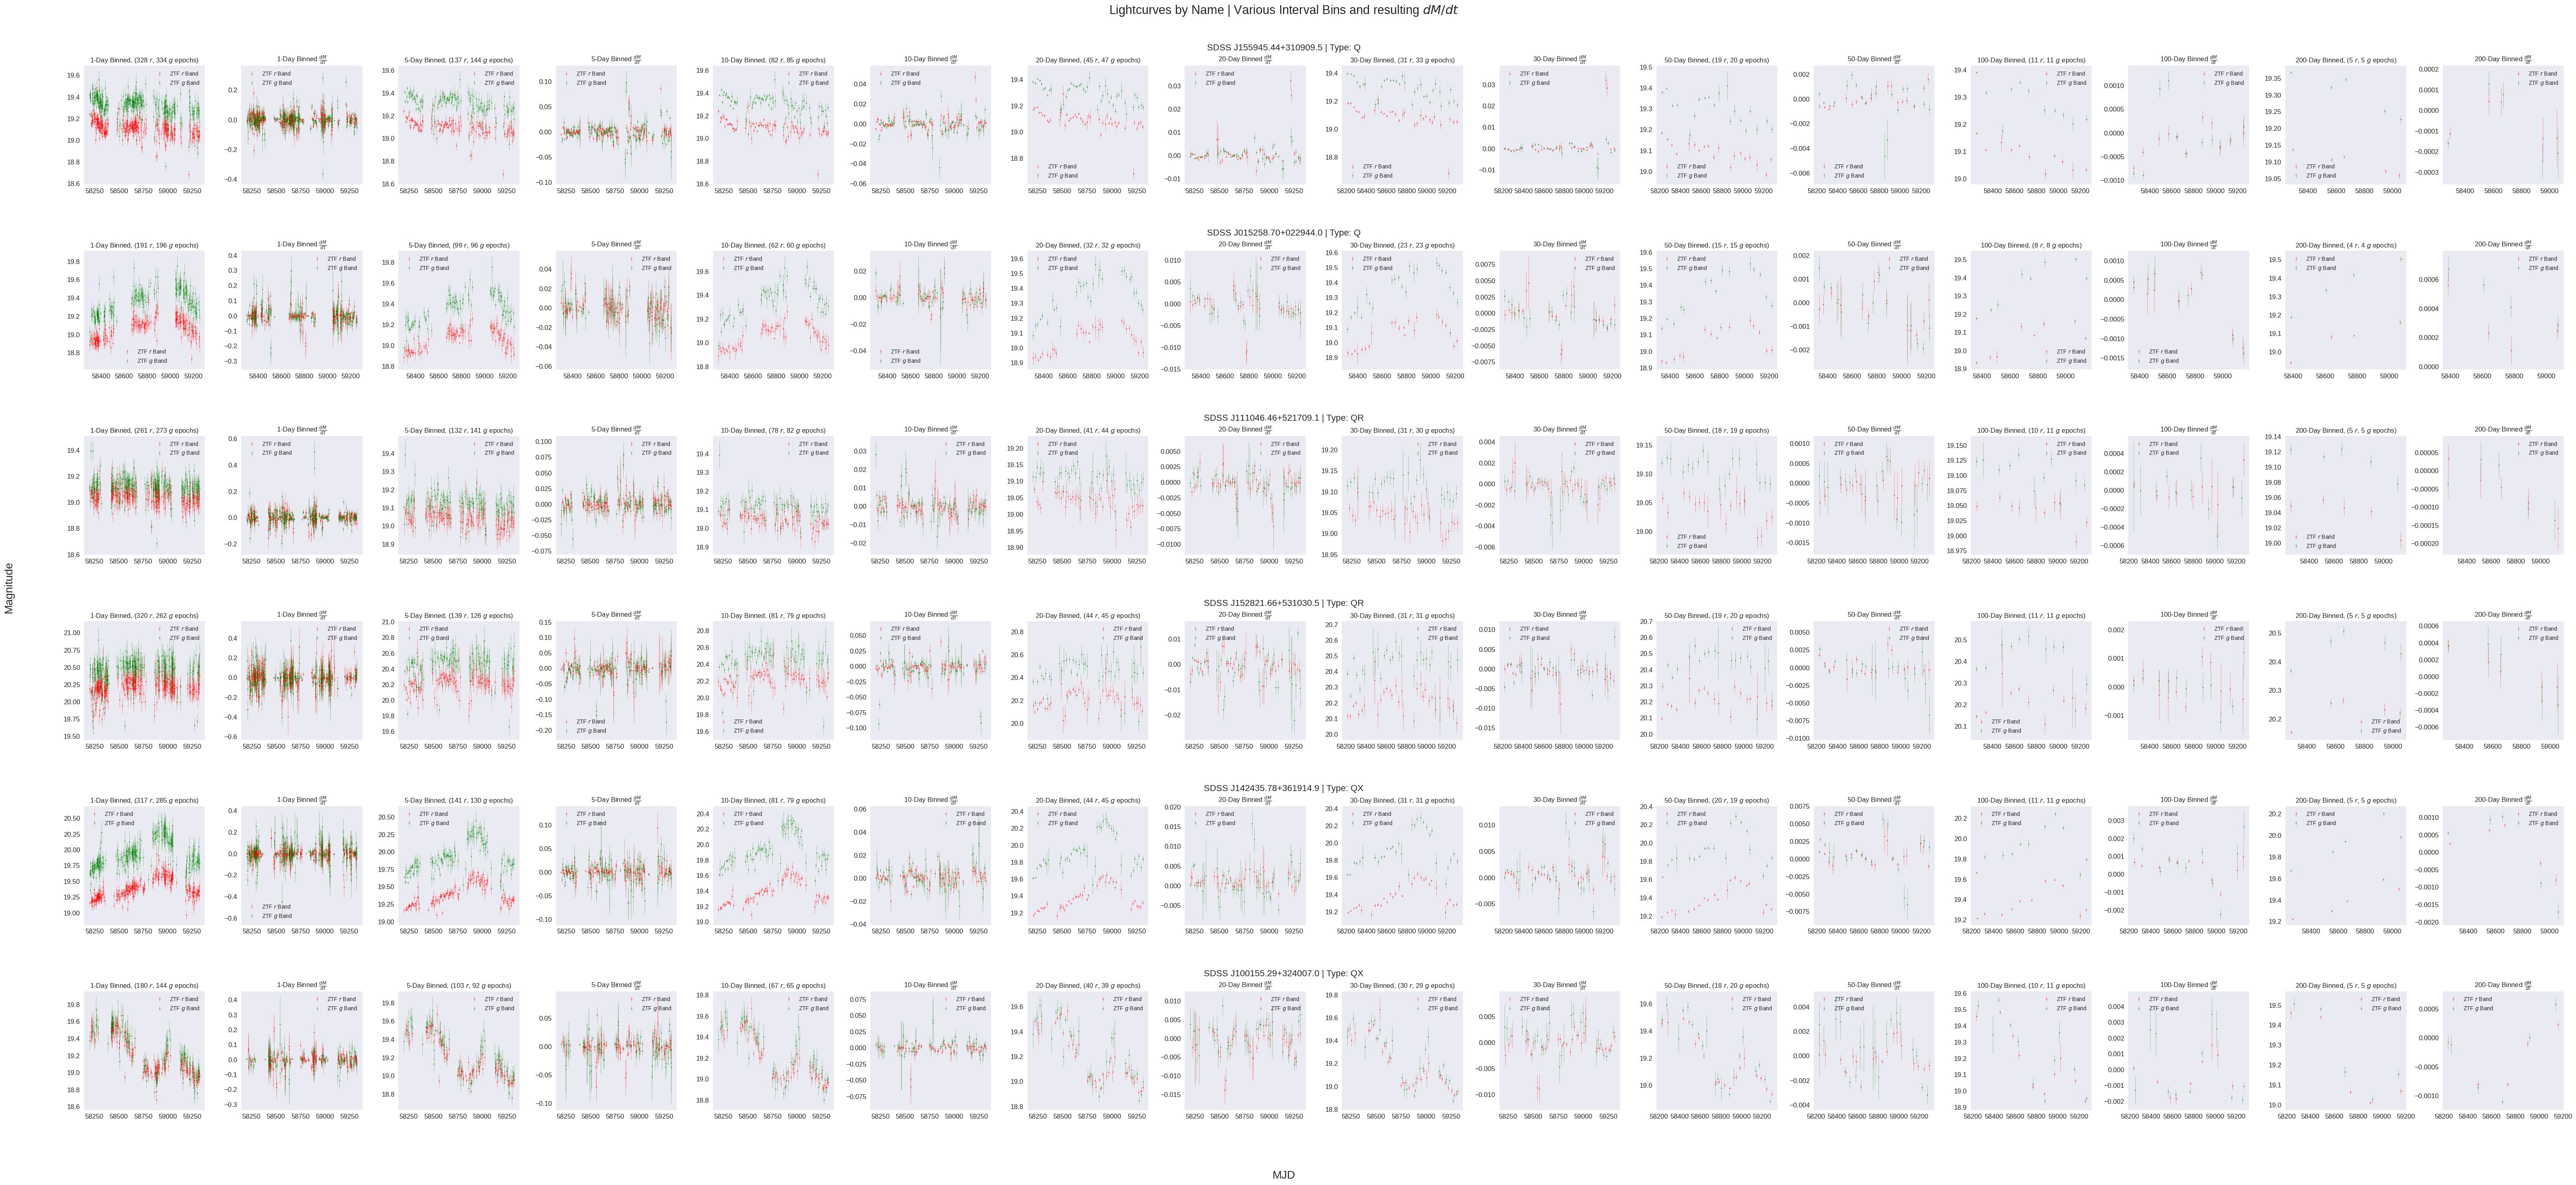

In [11]:
num_examples_per_type = 2
num_examples = num_examples_per_type * 3
sample_df = lightcurves_by_name.dropna(axis=0).query("type in @qso_types")
sample_df = sample_df.groupby('type').sample(num_examples_per_type).reset_index(drop=True)

nrows, ncols = num_examples, len(bin_intervals) * 2
fig = plt.figure(figsize=(ncols * 5, nrows * 4.5))
subfigs = fig.subfigures(nrows=nrows, ncols=1, hspace=0.2)

for i, (index, row) in enumerate(sample_df.iterrows()):
    axs = plot_single_subfig(subfigs[i], ncols=ncols, row=row)
    xlabel = axs[0].get_xlabel()
    ylabel = axs[0].get_ylabel()
    for ax in axs:
        ax.legend(fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('')

fig.suptitle('Lightcurves by Name | Various Interval Bins and resulting $dM / dt$', size=22, y=1.04)
fig.supxlabel(xlabel, size=20, y=-0.05)
fig.supylabel(ylabel, size=20, x=0.1)

# plt.tight_layout()
plt.show()

In [12]:
def return_combined_timeseries_err_arrays_from_series(series):
    errs_arrays = series.apply(lambda lc: lc[:, 2] if isinstance(lc, np.ndarray) else [np.nan]).to_numpy()
    errs_arrays_combined = np.concatenate(errs_arrays)
    return errs_arrays_combined

def return_combined_timeseries_percent_err_arrays_from_series(series):
    errs_arrays = series.apply(lambda lc: 100 * (lc[:, 2] / lc[:, 1]) if isinstance(lc, np.ndarray) else [np.nan]).to_numpy()
    errs_arrays_combined = np.concatenate(errs_arrays)
    errs_arrays_combined = errs_arrays_combined[~np.isinf(errs_arrays_combined)]
    return errs_arrays_combined

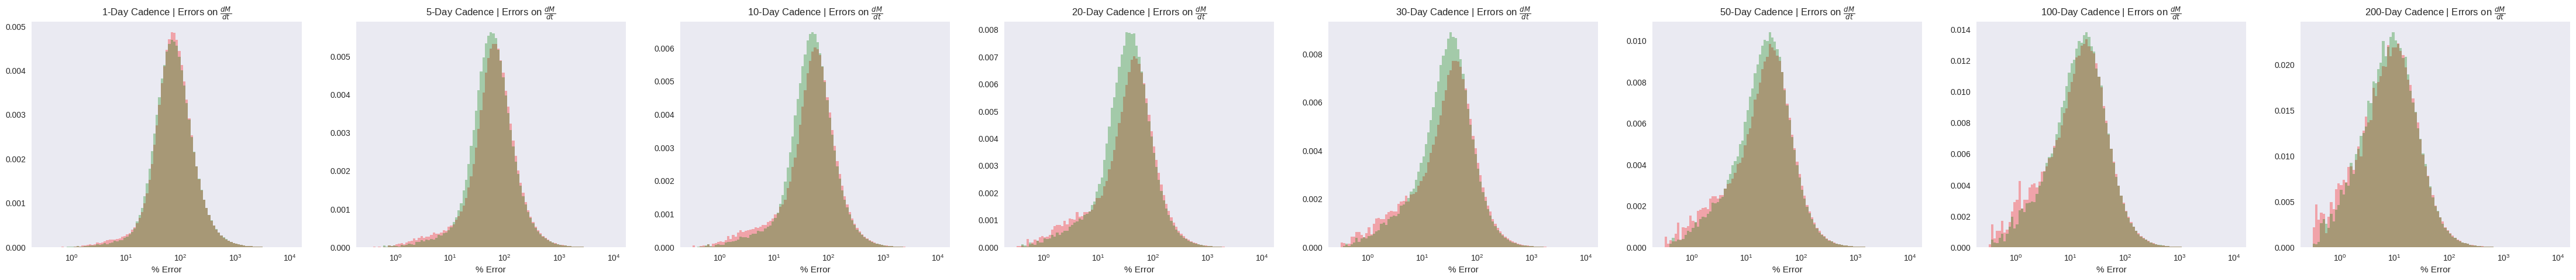

In [13]:
bins = np.logspace(-0.5, 4, 100)
alpha=0.3

fig, axs = plt.subplots(nrows=1, ncols=len(bin_intervals), figsize=(7 * len(bin_intervals), 5))

for ax, interval in zip(axs, bin_intervals):
    r_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_name[f'r_dmdt_curve_{interval}days'])
    g_errs = return_combined_timeseries_percent_err_arrays_from_series(lightcurves_by_name[f'g_dmdt_curve_{interval}days'])
    ax.hist(r_errs, bins=bins, color='r', alpha=alpha, density=True)
    ax.hist(g_errs, bins=bins, color='g', alpha=alpha, density=True)
    ax.set_title(f'{interval}-Day Cadence | Errors on $\\frac{{dM}}{{dt}}$')
    ax.set_xlabel('% Error')
    ax.set_xscale('log')

plt.show()

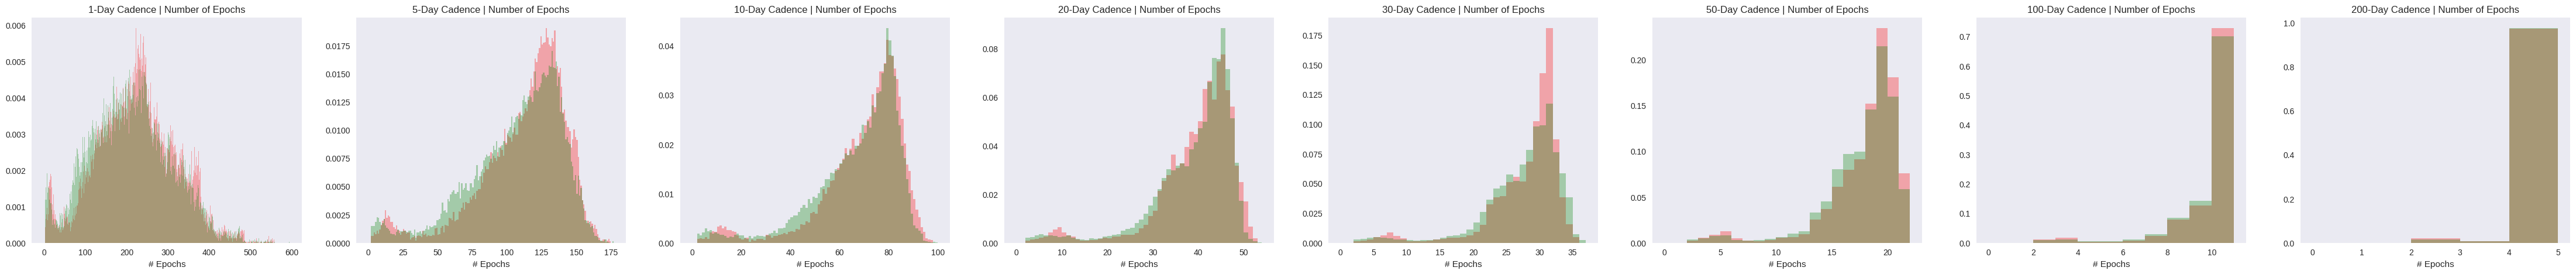

In [14]:
alpha=0.3

fig, axs = plt.subplots(nrows=1, ncols=len(bin_intervals), figsize=(7 * len(bin_intervals), 5))

for ax, interval in zip(axs, bin_intervals):
    r_n_good_dets = lightcurves_by_name[f'r_n_good_det_{interval}days'].dropna().to_numpy()
    g_n_good_dets = lightcurves_by_name[f'g_n_good_det_{interval}days'].dropna().to_numpy()

    r_bins = np.linspace(0, int(r_n_good_dets.max()), int(r_n_good_dets.max()) + 1)
    g_bins = np.linspace(0, int(g_n_good_dets.max()), int(g_n_good_dets.max()) + 1)

    ax.hist(r_n_good_dets, bins=r_bins, color='r', alpha=alpha, density=True)
    ax.hist(g_n_good_dets, bins=g_bins, color='g', alpha=alpha, density=True)
    ax.set_title(f'{interval}-Day Cadence | Number of Epochs')
    ax.set_xlabel('# Epochs')
    # ax.set_xscale('log')

plt.show()